<a href="https://colab.research.google.com/github/katjasit0815/Data-Science-academic-projects/blob/main/05_Animal_faces_classification%2C_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import pandas as pd
import kagglehub
import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [ ]:
path = kagglehub.dataset_download("andrewmvd/animal-faces")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'animal-faces' dataset.
Path to dataset files: /kaggle/input/animal-faces


In [ ]:
train_path = os.path.join(path+'/afhq', 'train')
val_path = os.path.join(path+'/afhq', 'val')

In [ ]:
train_df = pd.DataFrame()
val_df = pd.DataFrame()

In [ ]:
train_df['images'] = os.listdir(train_path+'/cat') + os.listdir(train_path+'/dog') + os.listdir(train_path+'/wild')
val_df['images'] = os.listdir(val_path+'/cat') + os.listdir(val_path+'/dog') + os.listdir(val_path+'/wild')

In [ ]:
train_df.head()

,images
0,pixabay_cat_000354.jpg
1,pixabay_cat_002763.jpg
2,pixabay_cat_001283.jpg
3,pixabay_cat_003423.jpg
4,flickr_cat_000496.jpg


In [ ]:
classes_train = []
paths_train = []

for image in train_df['images']:
    class_ = image.split('_')[1]
    classes_train.append(class_)
    paths_train.append(train_path+'/'+class_+'/'+image)

train_df['classes'] = classes_train
train_df['path'] = paths_train

classes_val = []
paths_val = []

for image in val_df['images']:
    class_ = image.split('_')[1]
    classes_val.append(class_)
    paths_val.append(val_path+'/'+class_+'/'+image)

val_df['classes'] = classes_val
val_df['path'] = paths_val

In [ ]:
train_df.head()

,images,classes,path
0,pixabay_cat_000354.jpg,cat,/kaggle/input/animal-faces/afhq/train/cat/pixa...
1,pixabay_cat_002763.jpg,cat,/kaggle/input/animal-faces/afhq/train/cat/pixa...
2,pixabay_cat_001283.jpg,cat,/kaggle/input/animal-faces/afhq/train/cat/pixa...
3,pixabay_cat_003423.jpg,cat,/kaggle/input/animal-faces/afhq/train/cat/pixa...
4,flickr_cat_000496.jpg,cat,/kaggle/input/animal-faces/afhq/train/cat/flic...


In [ ]:
val_df.head()

,images,classes,path
0,pixabay_cat_001635.jpg,cat,/kaggle/input/animal-faces/afhq/val/cat/pixaba...
1,flickr_cat_000314.jpg,cat,/kaggle/input/animal-faces/afhq/val/cat/flickr...
2,flickr_cat_000177.jpg,cat,/kaggle/input/animal-faces/afhq/val/cat/flickr...
3,pixabay_cat_001385.jpg,cat,/kaggle/input/animal-faces/afhq/val/cat/pixaba...
4,pixabay_cat_003432.jpg,cat,/kaggle/input/animal-faces/afhq/val/cat/pixaba...


##EDA

In [ ]:
print('Пропущенных значений в train_df:\n',train_df.isnull().sum())
print('\nПропущенных значений в val_df:\n',val_df.isnull().sum())

Пропущенных значений в train_df:
 images     0
classes    0
path       0
dtype: int64

Пропущенных значений в val_df:
 images     0
classes    0
path       0
dtype: int64


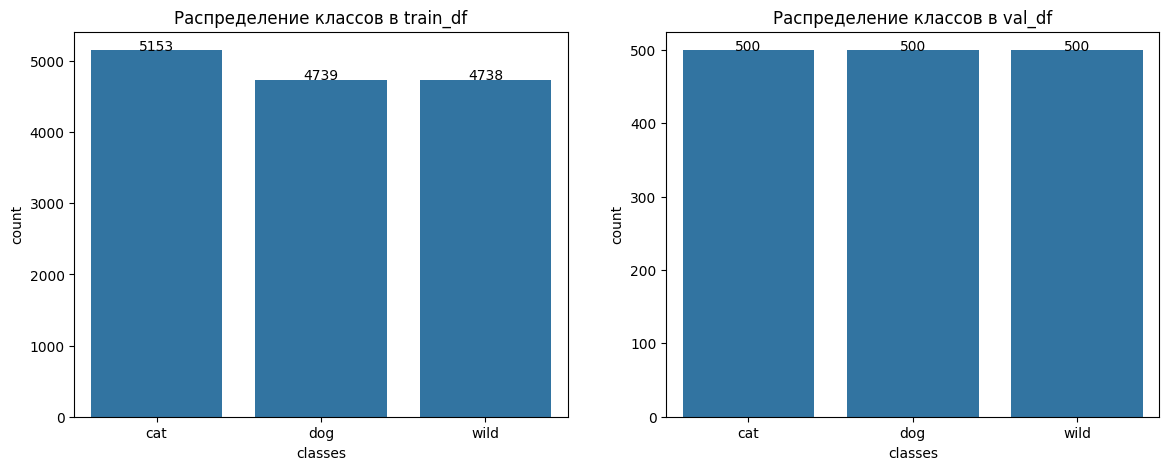

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='classes', data=train_df)
ax1.set_title("Распределение классов в train_df")

for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width() / 2.,
             height + 0.1,
             f'{int(height)}',
             ha="center")

plt.subplot(1, 2, 2)

ax2 = sns.countplot(x='classes', data=val_df)
ax2.set_title("Распределение классов в val_df")
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width() / 2.,
             height + 0.1,
             f'{int(height)}',
             ha="center")

In [ ]:
widths_tr, heights_tr, widths_val, heights_val = [],[],[],[]
for path in tqdm(train_df["path"]):
    width, height = Image.open(path).size
    widths_tr.append(width)
    heights_tr.append(height)

for path in tqdm(val_df["path"]):
    width, height = Image.open(path).size
    widths_val.append(width)
    heights_val.append(height)

100%|██████████| 1500/1500 [00:12<00:00, 123.23it/s]


In [ ]:
print(f'Уникальные расширения изображений в train_df: {set(widths_tr), set(heights_tr)}')
print(f'Уникальные расширения изображений в train_df: {set(widths_val), set(heights_val)}')

Уникальные расширения изображений в train_df: ({512}, {512})
Уникальные расширения изображений в train_df: ({512}, {512})


Таикм образом, данные в train и val датафреймах распределены равномерно, данные без пропусков. Все изображения одинакового размера: 512x512. Посмотрим на содержимое изображений.

(512, 512, 3)


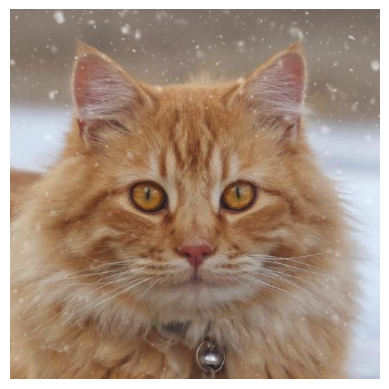

In [ ]:
img = np.asarray(Image.open(paths_train[0]))
plt.axis('off')
plt.imshow(img)
print(img.shape)

In [ ]:
def plot_species(df, animal_name, title):
    plt.figure(figsize = (12,12))
    species_df = df[df['classes'] == animal_name].reset_index(drop = True)
    plt.suptitle(f"Случайные изображения класса {animal_name} из датасета {title}",
        fontsize=10)
    for idx,i in enumerate(np.random.choice(species_df['path'],8)):
        plt.subplot(8,8,idx+1)
        image_path = i
        img = Image.open(image_path)
        img = img.resize((224,224))
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

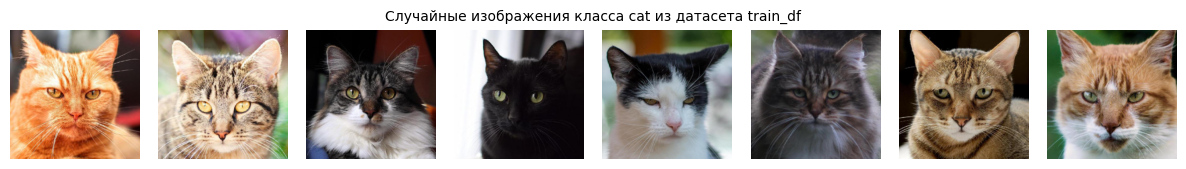

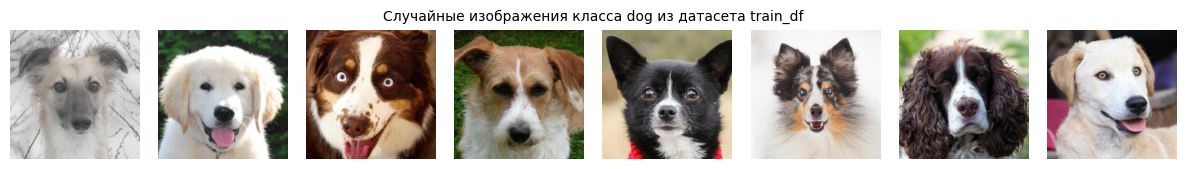

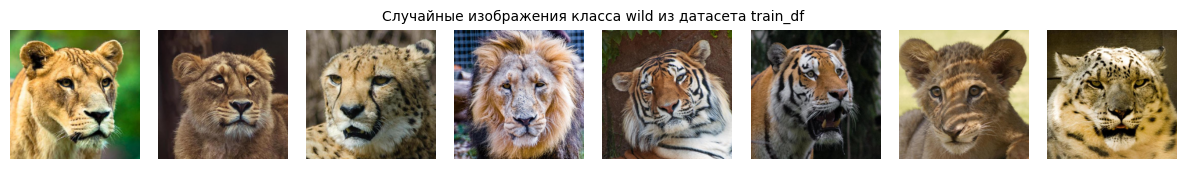

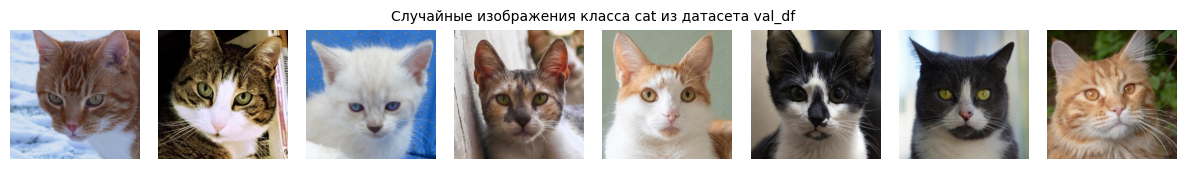

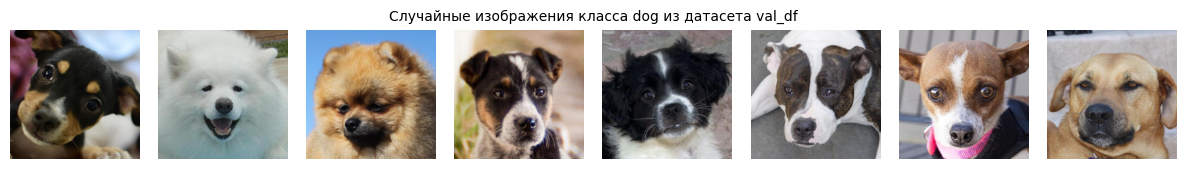

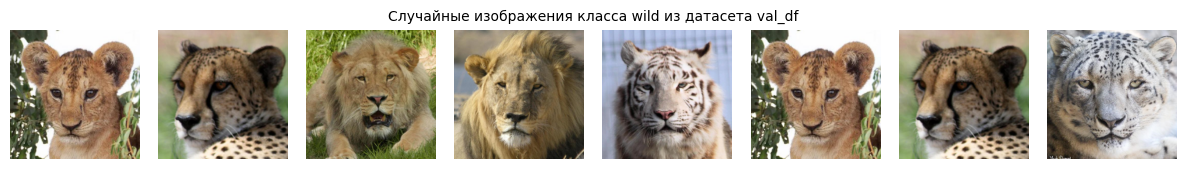

In [ ]:
for animal_name in train_df['classes'].unique():
    plot_species(train_df, animal_name,'train_df')
print('\n\n\n')
for animal_name in val_df['classes'].unique():
    plot_species(val_df, animal_name, 'val_df')

## Preprocessing, Data augmentation

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32
NUM_CLASSES = 3
AUTOTUNE = tf.data.AUTOTUNE

label_encoder = LabelEncoder()
label_encoder.fit(classes_train)
numeric_labels = label_encoder.transform(classes_train)
numeric_labels_val = label_encoder.transform(classes_val)

In [ ]:
def decode_and_resize(image_path, label):
    """Загружает изображение и изменяет его размер"""

    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) # Для resize
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bilinear')

    return img, label

In [ ]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((paths_train, numeric_labels))
    .shuffle(buffer_size=1024)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

def val_preprocess(file_path, label):
    img, label = decode_and_resize(file_path, label)
    return img, label

val_ds = (
    tf.data.Dataset.from_tensor_slices((paths_val, numeric_labels_val))
    .map(val_preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

## Learning

In [ ]:
base_model = keras.applications.EfficientNetB4(
                                       include_top=False,
                                       weights="imagenet",
                                       input_shape=(IMG_SIZE,IMG_SIZE,3),
                                       )
base_model.trainable = False # Замораживаем веса

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Аугментация
x = data_augmentation(inputs)

# Нормализация
x = tf.keras.layers.Lambda(efficientnet_preprocess)(x)

# Основная модель (вычисления в float16)
x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

Создадим отдельную директорию для хранения файлов с весами модели и настроим callback:

In [ ]:
WORKING_DIR = '/kaggle/working'

CHECKPOINT_SUBDIR = 'model_checkpoints'
CHECKPOINT_DIR = os.path.join(WORKING_DIR, CHECKPOINT_SUBDIR)

checkpoint_filename = 'best_model_EfficientNetB4.weights.h5'
checkpoint_filepath = os.path.join(CHECKPOINT_DIR, checkpoint_filename)

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss',mode='min',
    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)
    ]

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks_1,
    verbose=1
)

Epoch 1/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 179s 289ms/step - accuracy: 0.9689 - loss: 0.1058 - val_accuracy: 0.8160 - val_loss: 0.3147 - learning_rate: 0.0010
Epoch 2/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 100s 218ms/step - accuracy: 0.9900 - loss: 0.0339 - val_accuracy: 0.9933 - val_loss: 0.0436 - learning_rate: 0.0010
Epoch 3/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 100s 218ms/step - accuracy: 0.9945 - loss: 0.0160 - val_accuracy: 0.9967 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 4/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 100s 217ms/step - accuracy: 0.9974 - loss: 0.0110 - val_accuracy: 0.9967 - val_loss: 0.0268 - learning_rate: 0.0010
Epoch 5/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 100s 218ms/step - accuracy: 0.9971 - loss: 0.0107 - val_accuracy: 0.9967 - val_loss: 0.0226 - learning_rate: 0.0010
Epoch 6/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 100s 219ms/step - accuracy: 0.9972 - loss: 0.0084 - val_accuracy: 0.9973 - val_loss: 0.0221 - learning_rate: 0.0010
Epoch 7/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 144s 222ms/step - accura

## Fine-tuning

Результаты обучения отличные, однако попробуем запустить код для тонкой настройки модели. В лучшем случае будет получено незначительное увеличение уверенности модели в предсказаниях. Изменения, которые внесены:
*   lr стартовый уменьшен до 1e-7, lr для "плато" - до 1e-8
*   Отведено 20 эпох для тонкой настройки, а также 5 эпох для patience, если val_loss не будет уменьшаться.

In [ ]:
base_model.trainable = True
fine_tune_learning_rate = 1e-7

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

fine_tune_checkpoint_filename = 'best_model_EfficientNetB4_fine_tuned.weights.h5'
fine_tune_checkpoint_filepath = os.path.join(CHECKPOINT_DIR, fine_tune_checkpoint_filename)

callbacks_2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=fine_tune_checkpoint_filepath, monitor='val_loss',mode='min',
    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-8)
    ]

fine_tune_epochs = 20
epochs_learned = 23
total_epochs = epochs_learned + fine_tune_epochs

history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=epochs_learned,
    validation_data=val_ds,
    callbacks=callbacks_2,
    verbose=1
)

Epoch 24/43
458/458 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - accuracy: 0.4386 - loss: 1.6875 - val_accuracy: 0.9027 - val_loss: 0.2581 - learning_rate: 1.0000e-07
Epoch 25/43


KeyboardInterrupt: 

После первой эпохи обучения стало очевидно, что обучение излишне и его необходимо прервать, так как:

1. Accuracy значительно упал, а loss вырос.  
2. Обучение одной эпохи занимало чуть больше 6 минут.

Таким образом, размораживание всех слоев (base_model.trainable = True) привело к тому, что даже lr= 1e-7 был слишком высок для весов, которые уже достигли оптимума. Очевидно, что дальнейший тюнинг модели не требуется.

Рассмотрим полученные метрики.

## Validation

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
def train_val_eval(history_name=None):

    ''' Возвращает значения loss и acuraccy обученной модели по эпохам'''

    train_loss = history_name.history['loss']
    val_loss = history_name.history['val_loss']
    train_acc = history_name.history['accuracy']
    val_acc = history_name.history['val_accuracy']
    return train_loss, val_loss, train_acc, val_acc


def plot_training_history(history_name=None,start_epoch=1):

    ''' Строит кривые потерь и точности на train и val датасетах'''

    train_loss, val_loss, train_acc, val_acc=train_val_eval(history_name)
    range_epoch= np.arange(start_epoch, start_epoch + len(train_loss))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range_epoch, train_loss, label='Training Loss',marker='o', color='red')
    plt.plot(range_epoch, val_loss, label='Validation Loss',marker='x',color='blue')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    plt.subplot(1, 2, 2)
    plt.plot(range_epoch, train_acc, label='Training Accuracy',marker='o',color='red')
    plt.plot(range_epoch, val_acc, label='Validation Accuracy',marker='x',color='blue')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range_epoch)
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    plt.show()

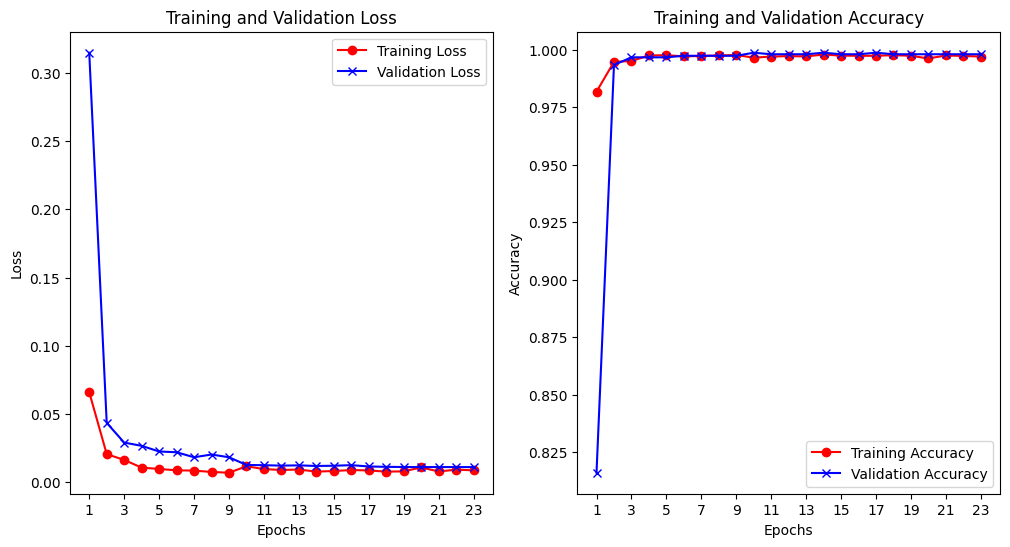

In [ ]:
plot_training_history(history_name=history)

In [ ]:
print("Доступные метрики:", history.history.keys())

Доступные метрики: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


In [ ]:
print(f"Метрики для последней эпохи:")
print(f"  Acurracy на train: {history.history['accuracy'][-1]:.4f}")
print(f"  Acurracy валидации: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Потери на train: {history.history['loss'][-1]:.4f}")
print(f"  Потери валидации: {history.history['val_loss'][-1]:.4f}")

Метрики для последней эпохи:
  Acurracy на train: 0.9970
  Acurracy валидации: 0.9980
  Потери на train: 0.0088
  Потери валидации: 0.0112


Таким образом, модель сходилась 23 эпохи, а значительное улучшение качества
(уменьшение loss) происходило в первые 10 эпох обучения.

Accuracy же достигло очень высокого значения уже на третьей эпохе. Также модель не переобучалась, т.к. кривые обучения не расходятся.

Посмотрим, какие изображения были распознаны неверно.

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step
Найдено 3 ошибок.


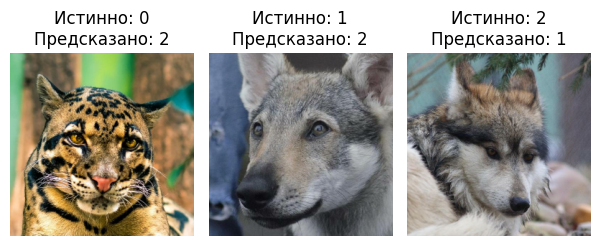

In [ ]:
X_val_list = []
y_val_list = []

for images, labels in val_ds:
    X_val_list.append(images.numpy())
    y_val_list.append(labels.numpy())

X_val_array = np.concatenate(X_val_list, axis=0)
y_val_array = np.concatenate(y_val_list, axis=0)
y_true_classes = y_val_array

y_pred_probabilities = model.predict(X_val_array)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

error_indices = np.where(y_true_classes != y_pred_classes)[0]
X_val_normalized = X_val_array / 255.0

print(f"Найдено {len(error_indices)} ошибок.")

plt.figure(figsize=(20, 4))
for i, wrong_id in enumerate(error_indices[:10]):

    img = X_val_normalized[wrong_id]
    plt.subplot(1, 10, i + 1)
    plt.title(
        f'Истинно: {y_true_classes[wrong_id]}\nПредсказано: {y_pred_classes[wrong_id]}',
        fontdict={'fontsize': 12},
    )
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Числовая метка {i} <--> Исходный класс '{class_name}'")

Числовая метка 0 <--> Исходный класс 'cat'
Числовая метка 1 <--> Исходный класс 'dog'
Числовая метка 2 <--> Исходный класс 'wild'


Таким образом, на валидационном датасете из 1500 изображений модель неверно классифицировала только 3 из них, причем на изображении 1 изображен явно дикий зверь. Замешательство модели на оставшихся двух фото также понятно, что в лишний раз показывает, что модель почти идеально справилась с задачей классификации.